In [1]:
%pip install grad-cam

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# https://github.com/jacobgil/pytorch-grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torch.utils.data import Dataset, DataLoader
from dataset import FilenameLabelImageDataset
from torchvision import transforms

DATA_FOLDER = 'mask_output/images'

transform = transforms.ToTensor()

dataset = FilenameLabelImageDataset(DATA_FOLDER, transform=transform, exclude_classes={"Region"})
data = DataLoader(dataset, batch_size=1, shuffle=True)


In [16]:
from model import CNN
import torch

model = CNN(num_classes=4)
model.load_state_dict(torch.load('best_model_good_one.pth'))

/home/dimitri/histopathologic-classifier/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/dimitri/histopathologic-classifier/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

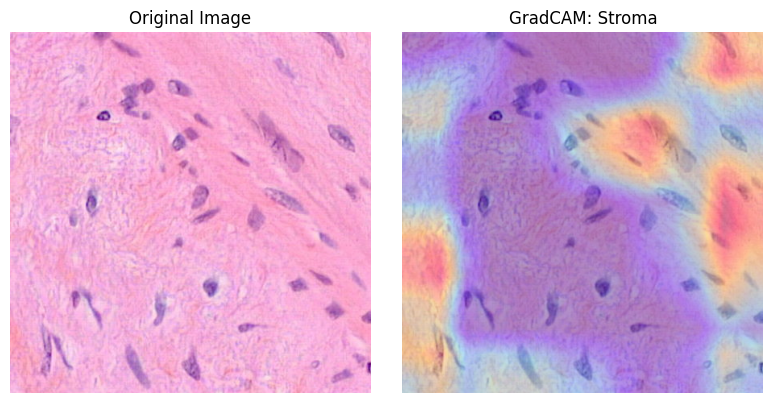

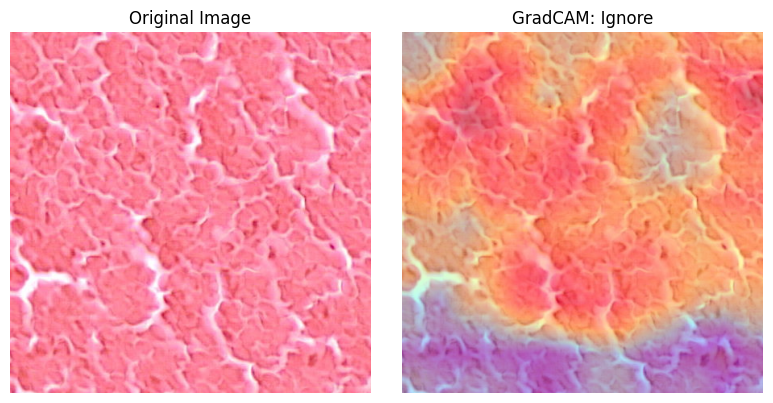

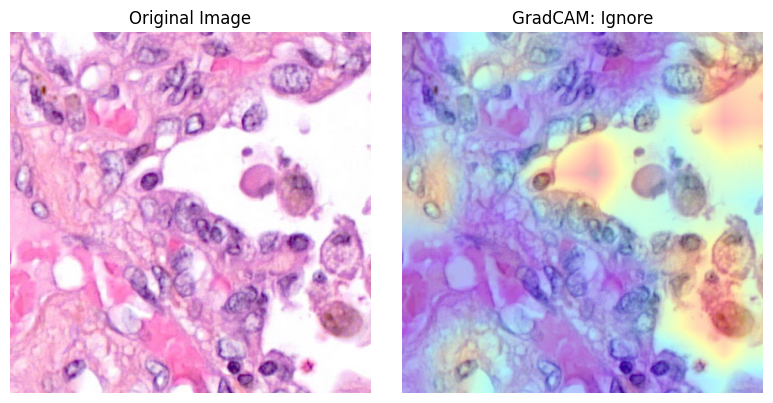

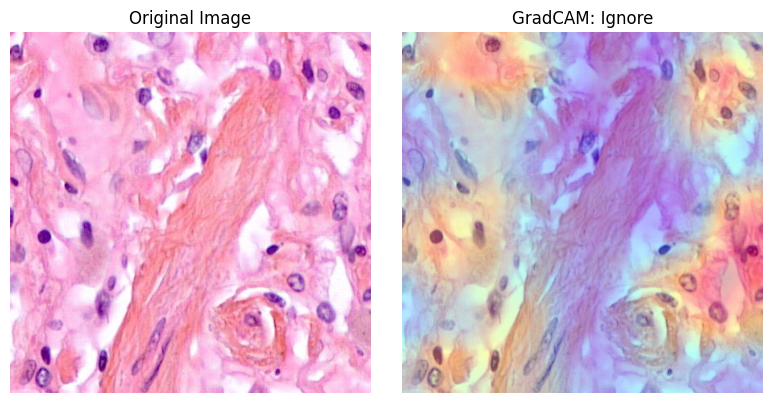

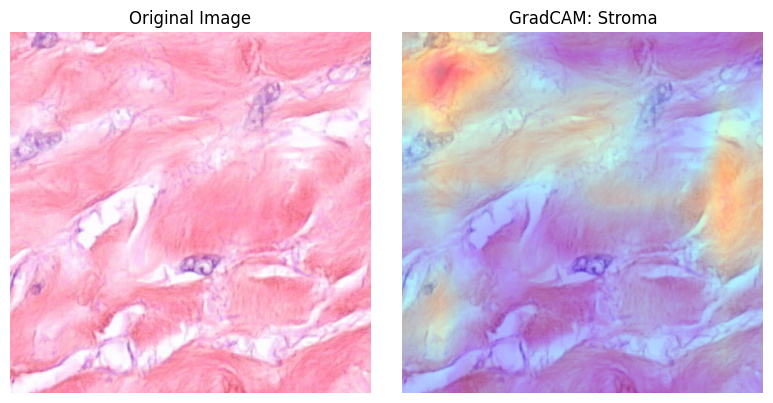

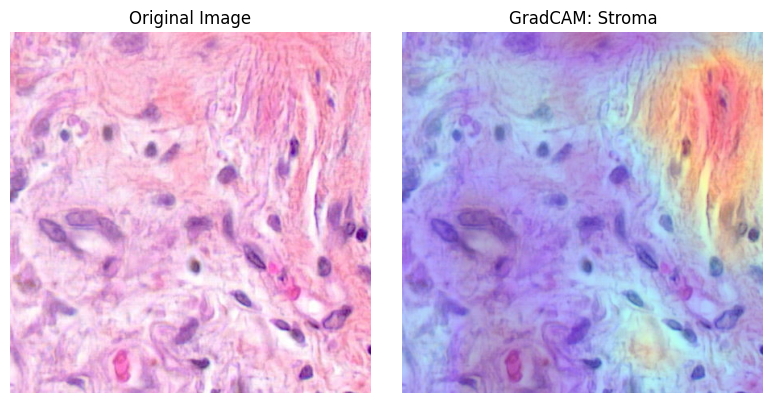

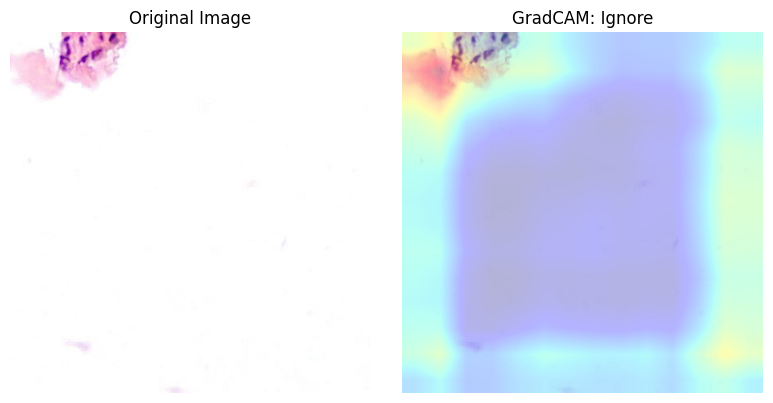

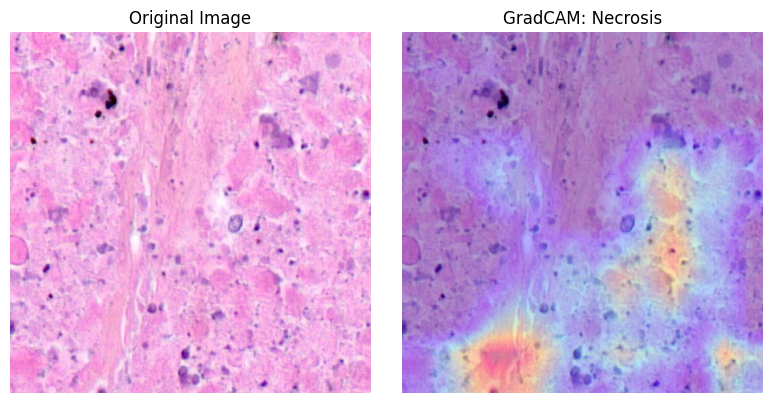

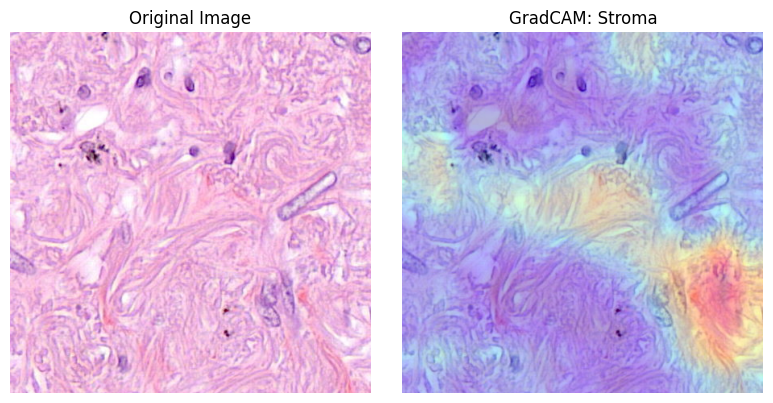

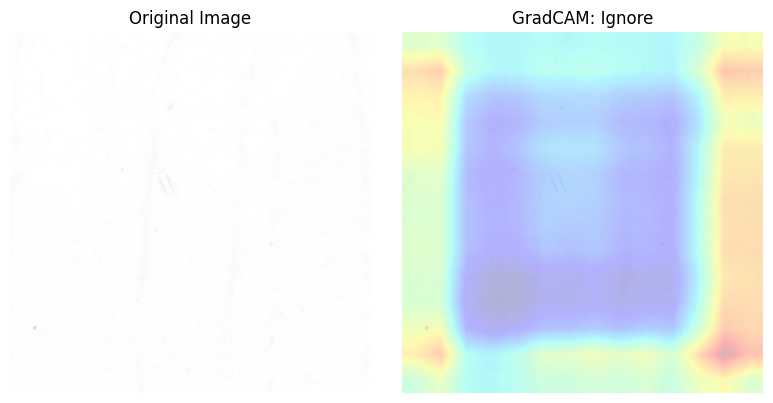

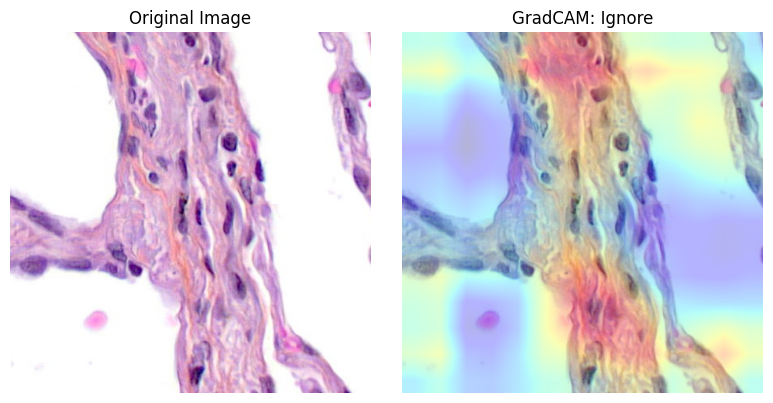

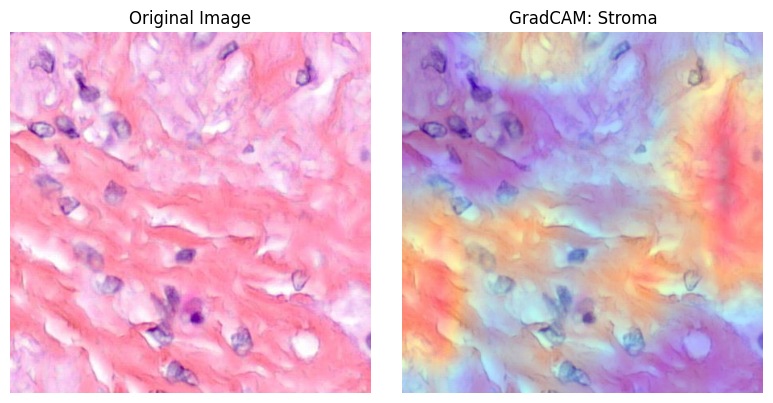

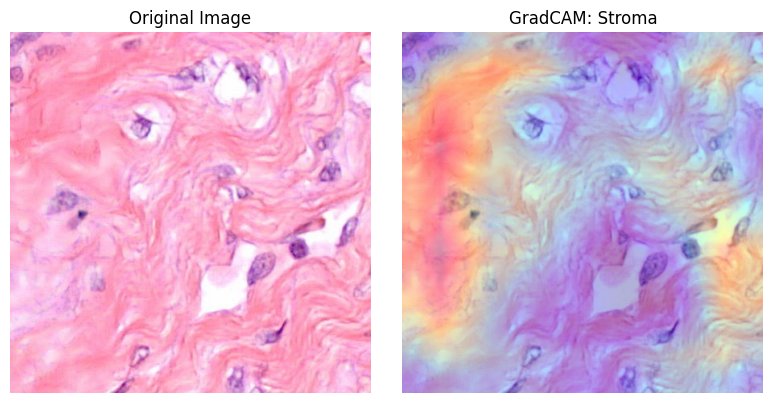

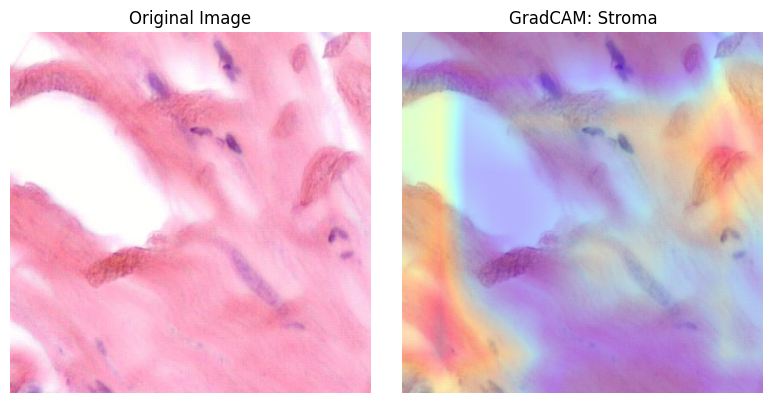

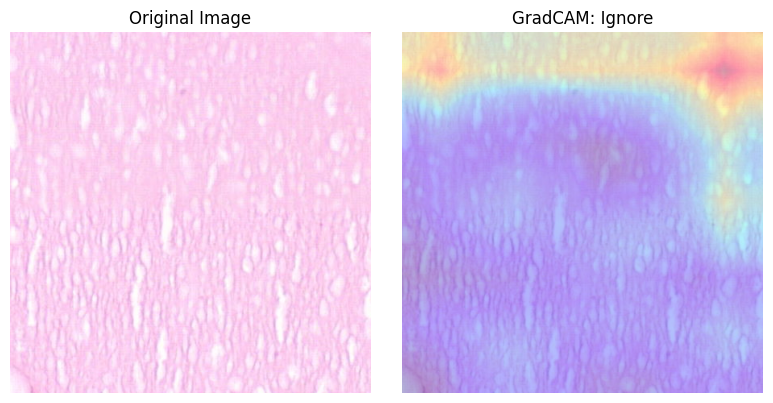

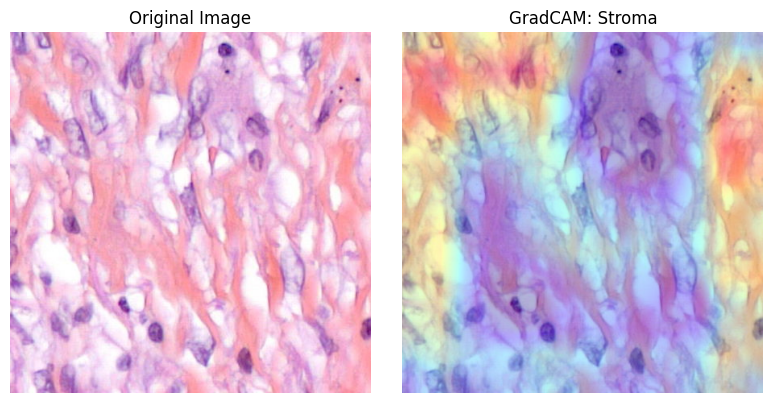

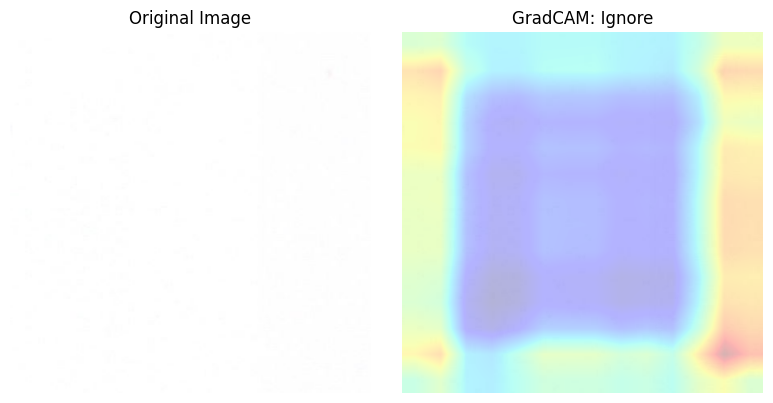

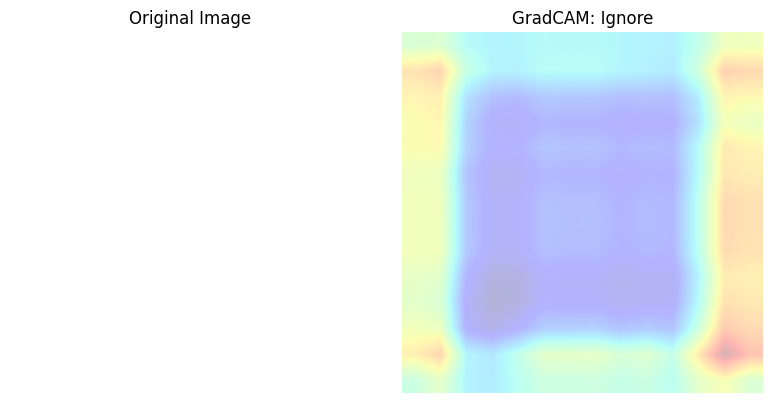

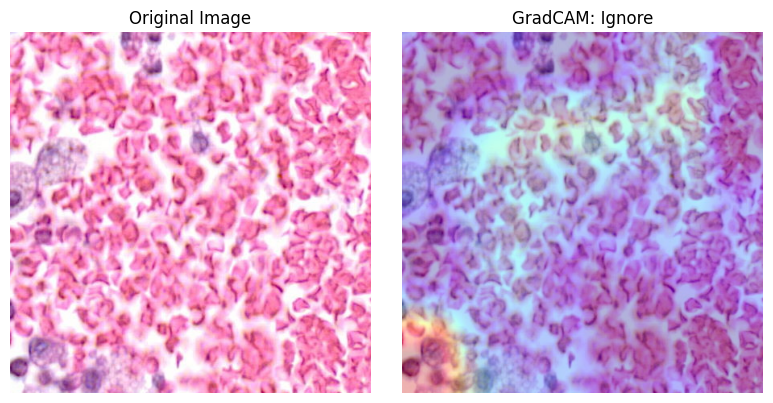

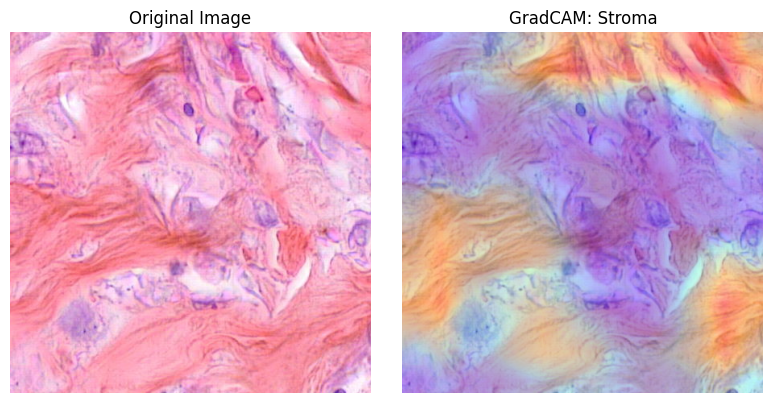

In [23]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

device = 'cuda' if torch.cuda.is_available() else 'cpu'

classes =  {'Ignore': 0, 'Necrosis': 1, 'Stroma': 2, 'Tumor': 3}
c = 0
for input_tensor, target_class in iter(data):
    input_tensor = input_tensor.to(device)
    target_layers = [model.model.layer4[-1]]
    targets = [ClassifierOutputTarget(target_class)]
    c += 1
    if c > 20:
        break
    with GradCAM(model=model, target_layers=target_layers) as cam:
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        # Visualize the CAM and the original image side by side
        to_pil = ToPILImage()
        rgb_img = to_pil(input_tensor[0].cpu().detach())

        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs[0].imshow(rgb_img)
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(rgb_img)
        axs[1].imshow(grayscale_cam, cmap='jet', alpha=0.3)  # Overlay
        axs[1].set_title(f"GradCAM: {list(classes.keys())[target_class.item()]}")
        axs[1].axis('off')

        plt.tight_layout()
        plt.show()